Import the GEE API

In [2]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AVHEtk7SA1mde-1L43s6A1j59u96AOXkOvHkzcWY6VDFKR1W95WOmIi_KDA

Successfully saved authorization token.


## Import data

In [3]:
# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

# Import the MODIS land cover collection.
lc = ee.ImageCollection("MODIS/006/MCD12Q1")

## Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')


filter the collection on the period of time we want. We can do that using the filterDate() method

In [4]:
# Initial date of interest (inclusive).
i_date = '2017-01-01'

## Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)



upload existing shape files 

In [5]:
##define some points

In [6]:
# Define the urban location Nairobi.
u_lon = 37.083375
u_lat = -1.038757
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location Kinangop Plateau.
r_lon = 36.554947
r_lat = -0.549995
r_poi = ee.Geometry.Point(r_lon, r_lat)


get information about our region/point of interest

In [7]:
scale = 1000  # scale in meters

# Print the elevation near Lyon, France.
elv_urban_point = elv.sample(r_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at rural point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(r_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at rural point:', round(lst_urban_point*0.02 -273.15, 2), '°C')


# Print the land cover type at the point.
lc_urban_point = lc.first().sample(r_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at rural point is:', lc_urban_point)

Ground elevation at rural point: 2435 m
Average daytime LST at rural point: 26.95 °C
Land cover value at rural point is: 9


In [8]:
scale = 1000  # scale in meters

# Print the elevation near Lyon, France.
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')


# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_urban_point)

Ground elevation at urban point: 1490 m
Average daytime LST at urban point: 32.47 °C
Land cover value at urban point is: 10


# time series

In [43]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()

# Get the data for the pixel intersecting the point in rural area.
lst_r_poi = lst.getRegion(r_poi, scale).getInfo()

# Preview the result.
lst_u_poi[:5]
lst_r_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01',
  36.55694048724393,
  -0.5524638997335057,
  1483228800000,
  None,
  2],
 ['2017_01_02',
  36.55694048724393,
  -0.5524638997335057,
  1483315200000,
  None,
  2],
 ['2017_01_03',
  36.55694048724393,
  -0.5524638997335057,
  1483401600000,
  15208,
  0],
 ['2017_01_04',
  36.55694048724393,
  -0.5524638997335057,
  1483488000000,
  15442,
  0]]

In [44]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

Here's what the function does:

Convert the array to a DataFrame using pd.DataFrame().
Move the headers to the first row and set them as column names.
Remove rows with missing values for longitude, latitude, time, and specified bands using dropna().
Convert the specified bands to numeric values using pd.to_numeric().
Convert the time field to a datetime using pd.to_datetime().
Keep only the columns of interest.
The resulting DataFrame will have a row for each unique combination of longitude, latitude, and time.

Note: The errors='coerce' argument in pd.to_numeric() is used to convert any non-numeric values to NaN

We apply this function to get the two time series we want (and print one).

In [45]:
lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

# Do the same for the rural point.
lst_df_rural = ee_array_to_df(lst_r_poi,['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()

,time,datetime,LST_Day_1km
2,1483401600000,2017-01-03,31.57
3,1483488000000,2017-01-04,37.11
5,1483660800000,2017-01-06,34.57
6,1483747200000,2017-01-07,37.63
7,1483833600000,2017-01-08,32.57


In [46]:
lst_df_rural.head()

,time,datetime,LST_Day_1km
2,1483401600000,2017-01-03,31.01
3,1483488000000,2017-01-04,35.69
4,1483574400000,2017-01-05,31.75
5,1483660800000,2017-01-06,33.17
6,1483747200000,2017-01-07,35.29


Now that we have our data in a good shape, we can easily make plots and compare the trends

This code defines a function fit_func() that takes as input four parameters: t, lst0, delta_lst, tau, and phi. This function returns the result of an equation that models diurnal LST variation as a sine wave.

The equation for the function is:

lst = lst0 + (delta_lst/2) * sin(2πt/tau + φ)

where lst is the predicted LST value at a given time t, lst0 is the baseline LST value, delta_lst is the amplitude of the LST variation, tau is the period of the LST variation (i.e., the time it takes for the variation to repeat), and phi is the phase of the LST variation.

The equation uses the numpy library's sin() and pi functions to compute the sine wave. The input t is the time in seconds

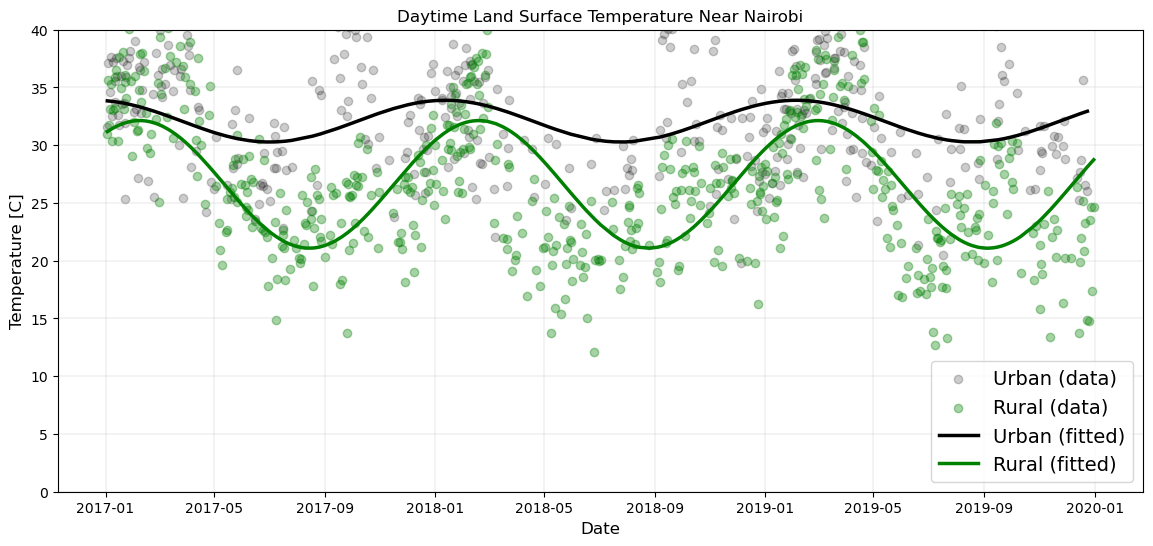

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))  # rural

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
params_r, params_covariance_r = optimize.curve_fit(
    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')
ax.scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
           c='green', alpha=0.35, label='Rural (data)')

# Add fitting curves.
ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)
ax.plot(lst_df_rural['datetime'],
        fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
        label='Rural (fitted)', color='green', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Nairobi', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature [C]', fontsize=12)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()